In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_excel('台鐵每日各站點進出站人數.xlsx', index_col=0)
print(data)

           staCode  gateInComingCnt  gateOutGoingCnt
trnOpDate                                           
20190423       900             8738             8040
20190423       910             1470             1424
20190423       920             2921             2581
20190423       930             6789             7011
20190423       940             2826             2872
...            ...              ...              ...
20200630      7360             3648             3779
20200630      7361               72               88
20200630      7362              159              183
20200630      7380              599              570
20200630      7390              414              404

[103347 rows x 3 columns]


In [3]:
# check column isnull or not

print(data['staCode'].isnull().sum())
print(data['gateInComingCnt'].isnull().sum())
print(data['gateOutGoingCnt'].isnull().sum())

# check size
print('check size')
data_size = data.groupby('staCode').size()
print(data_size)

# see data size if data size =/= 435
print('see data size if data size =/= 435')

for i in data_size:
    if i != 435:
        print(i)

0
0
0
check size
staCode
900     435
910     435
920     435
930     435
940     435
       ... 
7360    435
7361    434
7362    434
7380    435
7390    435
Length: 240, dtype: int64
see data size if data size =/= 435
434
6
285
129
289
433
434
426
434
432
434
434
434
434
434


In [4]:
data1 = data.groupby('staCode').mean()

data2 = data1['gateInComingCnt'].sort_values(ascending = False)
data2.index[:3]
staCode1, staCode2, staCode3 = data2.index[:3]
print(staCode1, staCode2, staCode3)

1000 1080 1100


In [5]:
# 1.資料期間，平均每日人數進站前三多的車站代碼

def top3_staCode_in(dataframe): 
    data1 = dataframe.groupby('staCode').mean()
    data2 = data1['gateInComingCnt'].sort_values(ascending = False) # 取進站平均 進行由大到小排序
    
    staCode1, staCode2, staCode3 = data2.index[:3] # 取前三大的 'staCode', Series
    
    return staCode1, staCode2, staCode3

top3_staCode_in(data)

(1000, 1080, 1100)

In [6]:
# 2.資料期間，平均每日人數出站前三多的車站代碼

def top3_staCode_out(dataframe): 
    data1 = dataframe.groupby('staCode').mean()
    data2 = data1['gateOutGoingCnt'].sort_values(ascending = False) # 取出站平均 進行由大到小排序
    
    staCode1, staCode2, staCode3 = data2.index[:3] # 取前三大的 'staCode'
    
    return staCode1, staCode2, staCode3

top3_staCode_out(data)

(1000, 1080, 1100)

In [7]:
# 3.每個月份，進出站落差最大的車站代碼
# 落差最大 -> 數量落差 or 百分比落差 

dataframe = data

# 數量落差
# data month #月份
data_m = pd.DataFrame({'date-mounth' : dataframe.index[:]//100, 
                       'staCode': dataframe['staCode'],
                       'gateInComingCnt' : dataframe['gateInComingCnt'],
                       'gateOutGoingCnt' : dataframe['gateOutGoingCnt'],
                       'InOut_diff' : dataframe['gateInComingCnt'] - dataframe['gateOutGoingCnt']
                      })

data_m_sum = data_m.groupby(['date-mounth', 'staCode']).sum() # 以月分先加總
print(data_m_sum)

# list of months 
months = list(set(data_m_sum.index.get_level_values("date-mounth")))
print(months)

for m in months:
    # use boolean mask, for each month dataframe
    data_m_sum_i = data_m_sum[data_m_sum.index.get_level_values("date-mounth") == m] # for different months

    # found max InOut_diff of stations
    max_diff_station = data_m_sum_i[data_m_sum_i['InOut_diff'].abs() == data_m_sum_i['InOut_diff'].abs().max()] 

    max_diff_staCode = max_diff_station.index.get_level_values(1)[0] # 取出 dataframe 中的 Index = 'staCode'
    max_diff_numbers = max_diff_station['InOut_diff'][0]
    
    print('{}年{:0>2d}月落差最大的staCode : {:<4d}, 人數是{}'.format( m//100, m%100, max_diff_staCode, max_diff_numbers))

                     gateInComingCnt  gateOutGoingCnt  InOut_diff
date-mounth staCode                                              
201904      900                67693            63678        4015
            910                11193            11284         -91
            920                21143            18994        2149
            930                50618            51724       -1106
            940                21673            21454         219
...                              ...              ...         ...
202006      7360              118308           124194       -5886
            7361                2808             3363        -555
            7362                6171             7291       -1120
            7380               17136            17029         107
            7390               11413            12177        -764

[3586 rows x 3 columns]
[201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005, 2020

In [8]:
dataframe = data

# 百分比落差
# data month #月份
data_m = pd.DataFrame({'date-mounth' : dataframe.index[:]//100, 
                       'staCode': dataframe['staCode'],
                       'gateInComingCnt' : dataframe['gateInComingCnt'],
                       'gateOutGoingCnt' : dataframe['gateOutGoingCnt'],
                       'InOut_diff' : dataframe['gateInComingCnt'] - dataframe['gateOutGoingCnt']
                      })

data_m_sum = data_m.groupby(['date-mounth', 'staCode']).sum() # 以月分先加總
print(data_m_sum)

# 除以(進站+出站)人數 -> 百分比

data_m_sum['percentage_diff'] = data_m_sum['InOut_diff']/(data_m_sum['gateInComingCnt'] + data_m_sum['gateOutGoingCnt'])
print(data_m_sum)

# list of months 
months = list(set(data_m_sum.index.get_level_values("date-mounth")))

for m in months:
    # use boolean mask, for each month dataframe
    data_m_sum_i = data_m_sum[data_m_sum.index.get_level_values("date-mounth") == m] # for different months

    # found max InOut_diff of stations
    max_diff_station = data_m_sum_i[data_m_sum_i['percentage_diff'].abs() == data_m_sum_i['percentage_diff'].abs().max()] 

    max_diff_staCode = max_diff_station.index.get_level_values(1)[0] # 取出 dataframe 中的 Index = 'staCode'
    max_diff_numbers = max_diff_station['InOut_diff'][0]
    max_diff_percentage = max_diff_station['percentage_diff'][0]
    
    print('{}年{:0>2d}月落差最大百分比的staCode : {:<4d}, 比例是{}%, 人數差距{}'
          .format( m//100, m%100, max_diff_staCode, int(max_diff_percentage*100), max_diff_numbers))

                     gateInComingCnt  gateOutGoingCnt  InOut_diff
date-mounth staCode                                              
201904      900                67693            63678        4015
            910                11193            11284         -91
            920                21143            18994        2149
            930                50618            51724       -1106
            940                21673            21454         219
...                              ...              ...         ...
202006      7360              118308           124194       -5886
            7361                2808             3363        -555
            7362                6171             7291       -1120
            7380               17136            17029         107
            7390               11413            12177        -764

[3586 rows x 3 columns]
                     gateInComingCnt  gateOutGoingCnt  InOut_diff  \
date-mounth staCode                             

In [9]:
# 4.每個車站每月進站與出站人數的平均值、標準差、四分位數
# 可以使用 describe()

dataframe = data

# data month #月份
data_m = pd.DataFrame({'date-mounth' : dataframe.index[:]//100, 
                       'staCode': dataframe['staCode'],
                       'gateInComingCnt' : dataframe['gateInComingCnt'],
                       'gateOutGoingCnt' : dataframe['gateOutGoingCnt'],
                      })

data_m = data_m.groupby(['date-mounth', 'staCode']).mean() # 以月分先平均
print(data_m)

# list of months 
months = list(set(data_m_sum.index.get_level_values("date-mounth")))

##### 平均值
for m in months:
    # use boolean mask, for each month dataframe
    data_m_i = data_m[data_m.index.get_level_values("date-mounth") == m] # for different months
    print('{}年{:0>2d}月的車站平均人次'.format(m//100, m%100))
    print(data_m_i)
    
##### 標準差 
data_m = pd.DataFrame({'date-mounth' : dataframe.index[:]//100, 
                       'staCode': dataframe['staCode'],
                       'gateInComingCnt' : dataframe['gateInComingCnt'],
                       'gateOutGoingCnt' : dataframe['gateOutGoingCnt'],
                      })
data_m = data_m.groupby(['date-mounth', 'staCode']).std() # 以月分做 standard deviation
print(data_m)

for m in months:
    # use boolean mask, for each month dataframe
    data_m_i = data_m[data_m.index.get_level_values("date-mounth") == m] # for different months
    print('{}年{:0>2d}月的車站人次標準差'.format(m//100, m%100))
    print(data_m_i)
    
##### 四分位數
data_m = pd.DataFrame({'date-mounth' : dataframe.index[:]//100, 
                       'staCode': dataframe['staCode'],
                       'gateInComingCnt' : dataframe['gateInComingCnt'],
                       'gateOutGoingCnt' : dataframe['gateOutGoingCnt'],
                      })
data_m = data_m.groupby(['date-mounth', 'staCode']).describe() # 以月分 do all analyzing
print(data_m)

for m in months:
    # use boolean mask, for each month dataframe
    data_m_i = data_m[data_m.index.get_level_values("date-mounth") == m] # for different months
    print('{}年{:0>2d}月的車站人次分析(四分位數)'.format(m//100, m%100))
    print(data_m_i)

                     gateInComingCnt  gateOutGoingCnt
date-mounth staCode                                  
201904      900          8461.625000      7959.750000
            910          1399.125000      1410.500000
            920          2642.875000      2374.250000
            930          6327.250000      6465.500000
            940          2709.125000      2681.750000
...                              ...              ...
202006      7360         3943.600000      4139.800000
            7361           93.600000       112.100000
            7362          205.700000       243.033333
            7380          571.200000       567.633333
            7390          380.433333       405.900000

[3586 rows x 2 columns]
2019年04月的車站平均人次
                     gateInComingCnt  gateOutGoingCnt
date-mounth staCode                                  
201904      900             8461.625         7959.750
            910             1399.125         1410.500
            920             2642.875     

[239 rows x 2 columns]
2020年06月的車站平均人次
                     gateInComingCnt  gateOutGoingCnt
date-mounth staCode                                  
202006      900          7128.600000      6718.933333
            910          1244.766667      1279.000000
            920          2165.466667      2031.300000
            930          5521.133333      5626.966667
            940          2381.233333      2386.000000
...                              ...              ...
            7360         3943.600000      4139.800000
            7361           93.600000       112.100000
            7362          205.700000       243.033333
            7380          571.200000       567.633333
            7390          380.433333       405.900000

[239 rows x 2 columns]
                     gateInComingCnt  gateOutGoingCnt
date-mounth staCode                                  
201904      900           945.874491       834.056995
            910           143.540375       154.664614
            920    

[239 rows x 2 columns]
2020年02月的車站人次標準差
                     gateInComingCnt  gateOutGoingCnt
date-mounth staCode                                  
202002      900           774.257943       691.997859
            910           188.245798       181.185675
            920           356.228005       264.906183
            930           923.492187       963.097047
            940           449.996658       446.260941
...                              ...              ...
            7360          581.403453       789.347987
            7361           57.643652        60.871948
            7362          109.409330       123.679458
            7380          101.809491        90.287267
            7390           68.557247        64.024914

[239 rows x 2 columns]
2020年03月的車站人次標準差
                     gateInComingCnt  gateOutGoingCnt
date-mounth staCode                                  
202003      900           750.545303       607.300955
            910           225.620559       220.257537
 

2020年04月的車站人次分析(四分位數)
                    gateInComingCnt                                    \
                              count         mean          std     min   
date-mounth staCode                                                     
202004      900                30.0  5348.900000   904.941315  3671.0   
            910                30.0  1094.600000   232.854194   719.0   
            920                30.0  1842.633333   444.758321  1111.0   
            930                30.0  4854.766667  1322.921967  2616.0   
            940                30.0  2174.033333   564.025219  1214.0   
...                             ...          ...          ...     ...   
            7360               30.0  2808.600000   491.111238  1885.0   
            7361               30.0    26.766667    21.119828     1.0   
            7362               30.0    58.766667    44.480669    10.0   
            7380               30.0   514.000000   113.900440   300.0   
            7390             

In [10]:
# 5.計算進站人數和出站人數的相關係數
dataframe.pop('staCode')
print(dataframe.corr())

# don't forget .pop() output can modify dataframe
data = pd.read_excel('台鐵每日各站點進出站人數.xlsx', index_col=0)
dataframe = data

                 gateInComingCnt  gateOutGoingCnt
gateInComingCnt         1.000000         0.995512
gateOutGoingCnt         0.995512         1.000000


In [11]:
# 6. 利用訓練集訓練模型預測gateOutGoingCnt(出站人數)，並驗證預測效能。
# 請敘述為何選擇此模型
# Note. 訓練集範圍為（2019/4/23-2020/04/30)，測試集範圍為（2020/5/1 - 2020/6/30)

# 以車站為主，最後以迴圈做每個車站的預測
# 不以標準差篩選data 

#dataframe

# all station coed
all_staCode = sorted(list(set(dataframe['staCode'])))
#print(all_staCode) 

# 單一車站分析
# 多個車站 -> for 迴圈

s = all_staCode[0] # 選第一個車站
dataframe = dataframe[dataframe['staCode'] == s] # boolen mask -> 只要第一個車站

dataframe_train = dataframe[dataframe.index <= 20200430]
dataframe_test = dataframe[dataframe.index >= 20200501]

# 2019/4/23-2020/04/30 train
x_train = dataframe_train.index
y_train = pd.DataFrame(dataframe_train[[ 'gateOutGoingCnt']], columns = [ 'gateOutGoingCnt'])

# 2020/5/1 - 2020/6/30 test
x_test = dataframe_test.index
y_test = pd.DataFrame(dataframe_test[[ 'gateOutGoingCnt']], columns = [ 'gateOutGoingCnt'])


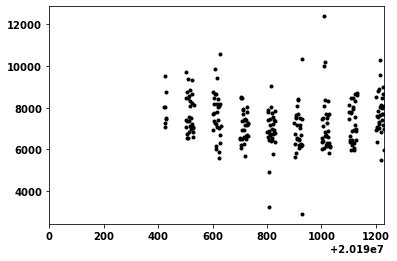

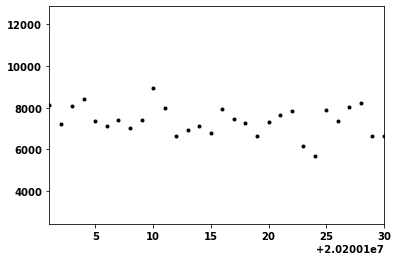

In [12]:
# 先畫個圖，看看有什麼規律性
plt.plot(abs(x_train), abs(y_train), 'k.')
plt.xlim(20190000, 20191230)
plt.show()

plt.plot(abs(x_train), abs(y_train), 'k.')
plt.xlim(20200101, 20200130)
plt.show()

In [13]:
#因為資料不連續性，假設變化有以年為周期變化
#猜想可能有以7天為次要周期的變化

# 要得到新的 feature week number, 星期幾
# 要把 2020和 2019 視為同一年


# 2019/4/23-2020/04/30 train
x_train = dataframe_train.index
y_train = pd.DataFrame(dataframe_train[[ 'gateOutGoingCnt']], columns = [ 'gateOutGoingCnt'])

# 2020/5/1 - 2020/6/30 test
x_test = dataframe_test.index
y_test = pd.DataFrame(dataframe_test[[ 'gateOutGoingCnt']], columns = [ 'gateOutGoingCnt'])


x_train, x_test, y_train, y_test


(Int64Index([20190423, 20190427, 20190429, 20190430, 20190501, 20190503,
             20190507, 20190508, 20190514, 20190516,
             ...
             20200418, 20200419, 20200420, 20200423, 20200424, 20200425,
             20200426, 20200427, 20200428, 20200429],
            dtype='int64', name='trnOpDate', length=374),
 Int64Index([20200502, 20200504, 20200505, 20200507, 20200508, 20200509,
             20200510, 20200517, 20200518, 20200521, 20200522, 20200523,
             20200525, 20200526, 20200528, 20200530, 20200531, 20200603,
             20200605, 20200609, 20200611, 20200612, 20200616, 20200618,
             20200619, 20200621, 20200623, 20200625, 20200627, 20200628,
             20200629, 20200501, 20200503, 20200506, 20200511, 20200512,
             20200513, 20200514, 20200515, 20200516, 20200519, 20200520,
             20200524, 20200527, 20200529, 20200601, 20200602, 20200604,
             20200606, 20200607, 20200608, 20200610, 20200613, 20200614,
             20

In [14]:
# 決定使用 天數
def to_days(x_train):
    x_train_day = []
    n_of_week = []
    days = []
    for i in x_train:
        year = int(i / 10000)
        month = int((i % 10000) / 100)
        day = int(i % 100)
        # 星期幾
        x_train_day.append('{}-{}-{}'.format(year, month, day))

        #第幾個星期
        n_week = datetime.date(year, month, day).isocalendar()[1]
        n_of_week.append(n_week) 

        #一年中第幾天
        d0 = datetime.date(year, 1, 1)
        d1 = datetime.date(year, month, day)
        days.append((d1 - d0).days)

    date = pd.DataFrame({'inputDate':x_train_day }) 
    date['inputDate'] = pd.to_datetime(date['inputDate']) 
    date['dayOfWeek'] = date['inputDate'].dt.dayofweek # 星期幾 day_name() 
    date['n_of_week'] = n_of_week
    date['days'] = days
    return date

0      112
1      116
2      118
3      119
4      120
      ... 
369    115
370    116
371    117
372    118
373    119
Name: days, Length: 374, dtype: int64 0     122
1     124
2     125
3     127
4     128
     ... 
56    171
57    173
58    175
59    177
60    181
Name: days, Length: 61, dtype: int64


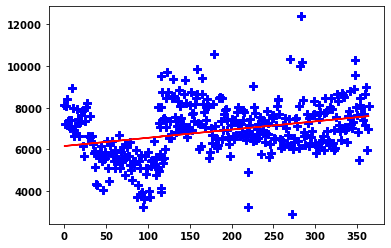

R-squared for training set: 0.0997


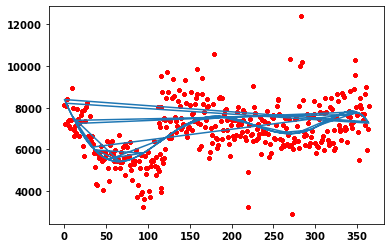

R-squared for training set: 0.3117
R-squared:-1.2775


In [15]:
# 決定使用 天數
# 把 2020和 2019 視為同一年


# 2019/4/23-2020/04/30 train
x_train = dataframe_train.index
y_train = pd.DataFrame(dataframe_train[[ 'gateOutGoingCnt']], columns = [ 'gateOutGoingCnt'])

# 2020/5/1 - 2020/6/30 test
x_test = dataframe_test.index
y_test = pd.DataFrame(dataframe_test[[ 'gateOutGoingCnt']], columns = [ 'gateOutGoingCnt'])

# x is days
x_train = to_days(x_train)['days']
x_test = to_days(x_test)['days']
print(x_train,x_test)

# try LinearRegression
model = LinearRegression()

x = x_train.values.reshape([-1,1])    #---convert to 2D array---
y = y_train.values.reshape([-1,1])     #---convert to 2D array---

# try 1 degree fitting
model.fit(x,y)

#---perform prediction---
y_pred = model.predict(x)

#---plot the training points---
plt.scatter(x, y,marker="P", s=50, color='b')

#---plot the straight line---
plt.plot(x, y_pred, color='r')
plt.show()

#---calculate R-squared---
print('R-squared for training set: {:.4f}'.format(model.score(x,y)))

###### degree = 4 ######

degree = 6
polynomial_features = PolynomialFeatures(degree = degree)

x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

#---plot the points---
#s==>scatter的size
plt.scatter(x, y,marker="P", s=10,c='r')

#---plot the regression line---
plt.plot(x, y_poly_pred)
plt.show()

#看看這個模型的解釋效果==>
print('R-squared for training set: {:.4f}'.format(model.score(x_poly,y)))

#用測試集測試模型
x = x_test.values.reshape([-1,1])    #---convert to 2D array---
y = y_test.values.reshape([-1,1])     #---convert to 2D array---

x_test_poly = polynomial_features.fit_transform(x)
print('R-squared:{:.4f}'.format(model.score(x_test_poly,y)))


In [16]:
# 日期
d0 = datetime.date(2008, 8, 18)
d1 = datetime.date(2008, 9, 26)
delta = d1 - d0
print(delta.days)

39
